In [2]:
# Uncomment the following line to install dprox if your are in the online google colab notebook
# !pip install dprox

# Integrated Energy System Planning (IESP)
The application domain of Integrated Energy System Planning (IESP) is a field that describes the energy system in mathematical models typically formulated as optimization problems. Solving energy planning tasks is essential in the transition to climate neutrality of regional and global energy systems, providing decision support to policymakers by gaining insights into complex interactions and dynamics of increasingly integrated energy systems, e.g., see [Schmitz et al., 2023](https://doi.org/10.1007/s12667-023-00595-y), [Böttger and Härtel 2022](https://doi.org/10.1016/j.eneco.2021.105709), [Craig et al. 2022](https://doi.org/10.1016/j.joule.2022.05.010), [Frischmuth et al. 2022](https://doi.org/10.1109/EEM54602.2022.9921154).

The planning problems corresponding to large-scale energy systems (easily up to 100 million decision variables) are typically formulated
as continuous linear programming (LP) problems.

## A reduced IESP problem instance
We consider an exemplary LP problem instance representing an IESP problem. It models a (reduced) multi-period capacity expansion and system operation planning problem instance which helps to develop transformation pathways of integrated energy systems.

### Importing the required packages

In [2]:
import os
import sys
from scipy import io
import scipy.sparse
import numpy as np

0
['d:\\01_repositories\\dprox\\Delta-Prox\\notebooks',
 'c:\\Users\\phaertel\\miniconda3\\envs\\dprox\\python311.zip',
 'c:\\Users\\phaertel\\miniconda3\\envs\\dprox\\DLLs',
 'c:\\Users\\phaertel\\miniconda3\\envs\\dprox\\Lib',
 'c:\\Users\\phaertel\\miniconda3\\envs\\dprox',
 '',
 'c:\\Users\\phaertel\\miniconda3\\envs\\dprox\\Lib\\site-packages',
 'c:\\Users\\phaertel\\miniconda3\\envs\\dprox\\Lib\\site-packages\\win32',
 'c:\\Users\\phaertel\\miniconda3\\envs\\dprox\\Lib\\site-packages\\win32\\lib',
 'c:\\Users\\phaertel\\miniconda3\\envs\\dprox\\Lib\\site-packages\\Pythonwin',
 'd:\\01_repositories\\dprox\\Delta-Prox\\notebooks\\..',
 'd:\\01_repositories\\dprox\\Delta-Prox\\notebooks\\..']


### Load problem instance 
Let us load a small IESP problem example in standard LP format. Note that the constraint matrix is stored in a sparse format and distinguishes equality (eq) and inequality (ub) constraints.

In [16]:
def load_lp_componentes_from_mat(filename):
    """
    Loads the linear program components from a .mat file.
    """
    model_components = io.loadmat(filename)
    A_ub = model_components["A_ub"]
    b_ub = model_components["b_ub"][0, :]
    A_eq = model_components["A_eq"]
    b_eq = model_components["b_eq"][0, :]
    c = model_components["c"][0, :]
    x_lb = model_components["x_lb"][0, :]
    x_ub = model_components["x_ub"][0, :]

    return (A_ub, b_ub, A_eq, b_eq, c, x_lb, x_ub)

# Load LP components
A_ub, b_ub, A_eq, b_eq, c, x_lb, x_ub = load_lp_componentes_from_mat("sample_data/iesp/esm_instance.mat")

### Problem size and coefficient statistics
Next, we report the problem size and coefficient statistics for the energy system planning problem. The problem size is reported in terms of the number of variables and constraints. The coefficient statistics are reported by the minimum and maximum values of non-zero coefficients in the corresponding linear problem matrices and vectors.

In [17]:
# Report problem size
print(f"Number of decision variables: {A_eq.shape[1]}")
print(f"Number of linear equality constraints: {A_eq.shape[0]}")
print(f"Number of linear inequality constraints (w/o bound constraints): {A_ub.shape[0]}\n")

# Report coefficient statistics
print("Coefficient statistics (positive non-zero) of model components:")
print(f"c \t: [{np.min(np.abs(c[c != 0])):3.2e}, {np.max(np.abs(c[c != 0])):3.2e}]")
print(f"A_eq \t: [{np.min(np.abs(A_eq[A_eq != 0])):3.2e}, {np.max(np.abs(A_eq[A_eq != 0])):3.2e}]")
print(f"A_ub \t: [{np.min(np.abs(A_ub[A_ub != 0])):3.2e}, {np.max(np.abs(A_ub[A_ub != 0])):3.2e}]")
print(f"b_eq \t: [{np.min(np.abs(b_eq[b_eq != 0])):3.2e}, {np.max(np.abs(b_eq[b_eq != 0])):3.2e}]")
print(f"b_ub \t: [{np.min(np.abs(b_ub[b_ub != 0])):3.2e}, {np.max(np.abs(b_ub[b_ub != 0])):3.2e}]")
print(f"x_ub \t: [{np.min(np.abs(x_ub[x_ub != 0])):3.2e}, {np.max(np.abs(x_ub[x_ub != 0])):3.2e}]")

Number of decision variables: 324150
Number of linear equality constraints: 52558
Number of linear inequality constraints (w/o bound constraints): 306604

Coefficient statistics (positive non-zero) of model components:
c 	: [1.00e-08, 4.38e-01]
A_eq 	: [9.59e-01, 1.07e+00]
A_ub 	: [1.01e-06, 6.00e+00]
b_eq 	: [1.00e+00, 1.96e+05]
b_ub 	: [4.80e+03, 2.00e+08]
x_ub 	: [inf, inf]


### Visualize the sparsity pattern of the linear problem matrices
Next, we visualize the sparsity pattern of the linear problem matrices. This is useful to get an idea of the structure of the problem and to check if the problem is formulated correctly.

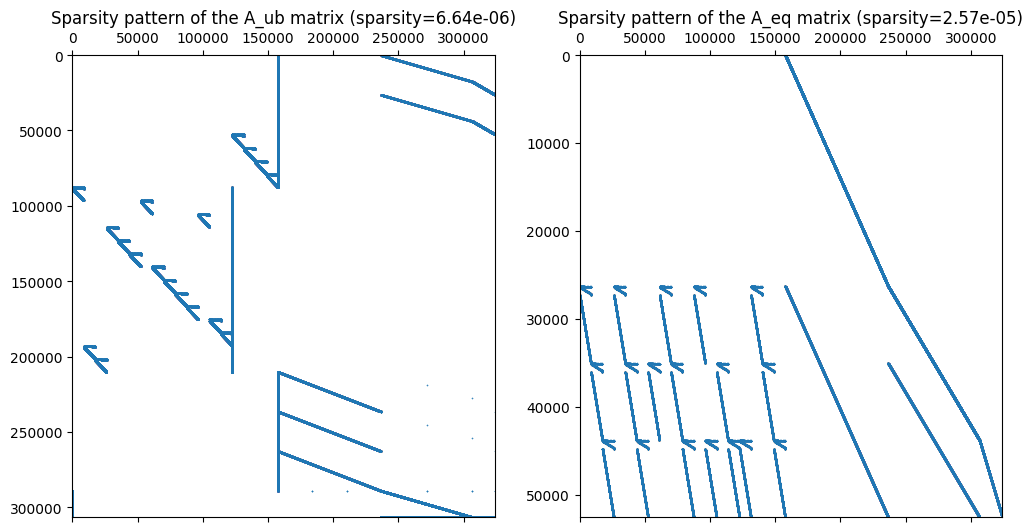

In [18]:
import matplotlib.pyplot as plt
def plot_sparsity_pattern(A, name):
    plt.spy(A, markersize=0.25, aspect="auto")
    plt.title(f"Sparsity pattern of the {name} matrix (sparsity={A.getnnz() / (A.shape[0] * A.shape[1]):.2e})")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_sparsity_pattern(A_ub, "A_ub")
plt.subplot(1, 2, 2)
plot_sparsity_pattern(A_eq, "A_eq")

Note that the energy system planning instance poses an ill-conditioned and sparse linear programming problem. Due to the different commodities, technologies, and actors involved, this is representative of energy system planning problems.

## Solving the IESP problem with Delta-Prox

### Preparation
First, we have to import the necessary libraries, configure the CUDA device and set necessary algorithm parameters.

In [7]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import time
import random
import torch
import dprox as dp

# Set device
if torch.cuda.device_count() > 0:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Set seed for reproducibility
random.seed(2023)
torch.manual_seed(2023)
np.random.seed(2023)

# Set algorithm parameters
max_iters = 100000
abs_tol = 5e-2
rel_tol = 1e-10
rho = 1e-2
dtype = torch.float64
norm_ord = float('inf')

### Solve the problem with Delta-Prox

In [26]:
# Initialize problem and solver
start = time.time()
lp_problem = dp.algo.lp.LPProblem(c, A_ub, b_ub, A_eq, b_eq, x_lb, x_ub, norm_ord=norm_ord, dtype=dtype, sparse=True, device=device)
lp_admm = dp.algo.lp.LPSolverADMM(rho=rho, problem_scale=None, abstol=abs_tol, reltol=rel_tol, max_iters=max_iters, dtype=dtype).to(device)

# Solve problem
with torch.no_grad():
    lp_admm.eval()
    x, history, res = lp_admm.solve(lp_problem, residual_balance=True)

x = x.cpu().numpy().squeeze()

print(res[0])

print(f'x >= 0 err: {x.min():.2e}')
print(f'Ax = b err: {np.abs(b_eq - A_eq @ x).max():.2e}')
print(f'Ax <= b err: {np.min(b_ub - A_ub @ x):.2e}')

torch.cuda.current_stream().synchronize()
end = time.time()
print(f"Time elapsed (LPADMM): {end-start:.4f}s\n")


Acnorm: 1.000, 1.000
Arnorm: 1.000, 1.000
dmax: 1.000
emax: 2.447
gamma_c: 2.283e+00
gamma_b: 2.496e-09


  0%|          | 0/100000 [00:00<?, ?it/s]

Obj: -2.18e+08, res_primal: 4.77e+07, res_dual: 2.63e-01, eps_primal: 5.48e-02, eps_dual: 5.00e-02, rho: 1.00e-02


  1%|          | 998/100000 [00:36<57:03, 28.91it/s]  

Obj: 7.30e+04, res_primal: 1.61e+04, res_dual: 1.03e-05, eps_primal: 7.00e-02, eps_dual: 5.00e-02, rho: 2.00e-02


  2%|▏         | 2000/100000 [01:17<1:15:48, 21.54it/s]

Obj: 7.82e+04, res_primal: 7.79e+03, res_dual: 3.24e-05, eps_primal: 7.00e-02, eps_dual: 5.00e-02, rho: 4.00e-02


  3%|▎         | 3000/100000 [02:09<1:25:48, 18.84it/s]

Obj: 8.05e+04, res_primal: 7.22e+03, res_dual: 9.57e-06, eps_primal: 7.00e-02, eps_dual: 5.00e-02, rho: 8.00e-02


  4%|▍         | 3999/100000 [03:07<1:35:36, 16.74it/s]

Obj: 8.13e+04, res_primal: 7.39e+03, res_dual: 9.69e-06, eps_primal: 7.00e-02, eps_dual: 5.00e-02, rho: 1.60e-01


  5%|▌         | 5000/100000 [04:19<1:49:17, 14.49it/s]

Obj: 8.17e+04, res_primal: 7.35e+03, res_dual: 2.44e-05, eps_primal: 7.00e-02, eps_dual: 5.00e-02, rho: 3.20e-01


  6%|▌         | 6000/100000 [05:38<1:59:16, 13.13it/s]

Obj: 8.21e+04, res_primal: 6.66e+03, res_dual: 7.00e-05, eps_primal: 7.00e-02, eps_dual: 5.00e-02, rho: 6.40e-01


  7%|▋         | 6999/100000 [07:12<2:33:36, 10.09it/s]

Obj: 8.22e+04, res_primal: 6.38e+03, res_dual: 9.19e-05, eps_primal: 7.00e-02, eps_dual: 5.00e-02, rho: 1.28e+00


  8%|▊         | 8000/100000 [08:56<2:41:11,  9.51it/s]

Obj: 8.23e+04, res_primal: 5.95e+03, res_dual: 1.17e-04, eps_primal: 7.00e-02, eps_dual: 5.00e-02, rho: 2.56e+00


  8%|▊         | 8323/100000 [09:32<1:45:05, 14.54it/s]


KeyboardInterrupt: 

Solving with dprox on a NVIDIA A100 GPU results in the following output:
```console
tensor([[83432.3454]], device='cuda:0', dtype=torch.float64)
x >= 0 err: -1.90e-02
Ax = b err: 1.33e-02
Ax <= b err: -5.98e-02
Time elapsed (LPADMM): 247.9268s
```

## Comparison with established CPU solvers
To compare the results and convergence behavior with established solvers, we use the proprietary [Gurobi Optimizer](https://www.gurobi.com/solutions/gurobi-optimizer/) and open-source [HiGHS](https://www.maths.ed.ac.uk/hall/HiGHS/) solvers.

### Gurobi
First, we solve the problem instance with the Gurobi solver via the [gurobipy](https://support.gurobi.com/hc/en-us/articles/360044290292-How-do-I-install-Gurobi-for-Python-) interface. Please note that this step requires a valid Gurobi license as it is a proprietary solver.

In [19]:
import gurobipy as gp
# Requires a license

m = gp.Model()
x = m.addMVar(c.shape[0], lb=x_lb, ub=x_ub)
m.setObjective(c @ x)
m.addConstr(A_eq @ x == b_eq)
m.addConstr(A_ub @ x <= b_ub)

m.params.Method = 2 # Interior Point Method (Barrier + crossover)

m.optimize()

Set parameter Method to value 2
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1280P, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 359162 rows, 324150 columns and 1097940 nonzeros
Model fingerprint: 0x5c086a86
Coefficient statistics:
  Matrix range     [1e-06, 6e+00]
  Objective range  [1e-08, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+08]
Presolve removed 23342 rows and 23342 columns
Presolve time: 0.70s
Presolved: 335820 rows, 300808 columns, 1051257 nonzeros

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 29
 AA' NZ     : 8.118e+05
 Factor NZ  : 6.011e+06 (roughly 300 MB of memory)
 Factor Ops : 1.558e+08 (less than 1 second per iteration)
 Threads    : 14

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.23410341e+08  0.00

```console
Solving with Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1280P
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

[...]

Solved in 292328 iterations and 85.80 seconds (355.13 work units)
Optimal objective  8.341841135e+04
```

### HiGHS
We use the [highspy](https://ergo-code.github.io/HiGHS/dev/interfaces/python/#python-getting-started) interface to solve the LP problem with HiGHS. The highspy interface is a python wrapper for the HiGHS solver.

In [20]:
# HiGHS
# pip install highspy

import highspy
import scipy.sparse

h = highspy.Highs()
h.addVars(len(c), x_lb, x_ub)
h.changeColsCost(len(c), np.arange(len(c), dtype=np.int32), c)

A = scipy.sparse.vstack((A_eq, A_ub))
b = np.hstack((b_eq, b_ub))

num_cons = A.shape[0]
A = A.tocsr()

lower=np.hstack((b_eq, -np.inf * np.ones_like(b_ub)))
upper=np.hstack((b_eq, b_ub))

h.addRows(num_cons, lower, upper, A.nnz, A.indptr, A.indices, A.data)

lp = h.getLp()
h.passModel(lp)
h.setOptionValue("log_to_console", True)
h.setOptionValue("solver", "ipm")

start = time.time()

h.run()

end = time.time()
print(f"Time elapsed: {end - start:.2f}s")

info = h.getInfo()
model_status = h.getModelStatus()
print('Model status = ', h.modelStatusToString(model_status))
print('Optimal objective = ', info.objective_function_value)
print('Iteration count = ', info.simplex_iteration_count)
print('Primal solution status = ', h.solutionStatusToString(info.primal_solution_status))
print('Dual solution status = ', h.solutionStatusToString(info.dual_solution_status))
print('Basis validity = ', h.basisValidityToString(info.basis_validity))

Time elapsed: 3555.89s
Model status =  Optimal
Optimal objective =  83418.40550119097
Iteration count =  57338
Primal solution status =  Feasible
Dual solution status =  Feasible
Basis validity =  Valid


```console
Time elapsed: 3555.89s
Model status =  Optimal
Optimal objective =  83418.40550119097
Iteration count =  57338
Primal solution status =  Feasible
Dual solution status =  Feasible
Basis validity =  Valid
```

## Summary
For the example IESP problem, we see that Delta-Prox can solve the problem with solutions times comparable to Gurobi and faster than HiGHS with accuracy close to the results of Gurobi and HiGHS.

Since Delta-Prox only relies on first-order methods, it offers substantial memory savings, which is key for large-scale problems as memory use presents a challenge for established CPU-based solvers and their second-order methods.